# Notebook 05: Baseline Evaluation

- compute accuracy and F1-score

In [1]:
!pwd

/mnt/d/Study/Python Scripts/scimilarity-finetune


# Imports

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import scanpy as sc
import torch.nn.functional as F
from torch.utils.data import DataLoader
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from peft import get_peft_model, LoraConfig, TaskType, PeftModel, PeftConfig, LoraModel
from tqdm import tqdm
from scimilarity.nn_models import Encoder, Decoder
import os
import json
from app.utils import load_preprocessed_data, load_artifacts, compute_embeddings, evaluate_knn
from app.model.wrapper import load_encoder, load_decoder, load_lora_encoder
from app.logger_config import get_logger
logger = get_logger()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

2025-10-19 12:41:56 | logger_config.py:get_logger:41 | INFO | Logger initialized successfully.
2025-10-19 12:41:56 | logger_config.py:get_logger:41 | INFO | Logger initialized successfully.


# Load processed datasets and artifacts

In [2]:
label_encoder, _, _, _ = load_artifacts()
num_classes = len(label_encoder.classes_)
logger.info(f"number of cell types: {num_classes}")

# String label → integer
label2int = {label: i for i, label in enumerate(label_encoder.classes_)}

# Integer → string label
int2label = {i: label for i, label in enumerate(label_encoder.classes_)}

logger.info(f"Sample int2label:, {list(int2label.items())[:5]}")

2025-10-19 12:42:09 | utils.py:load_artifacts:165 | INFO | ✅ Loaded LabelEncoder, gene order, and scaling stats.
2025-10-19 12:42:09 | 4123527393.py:<module>:3 | INFO | number of cell types: 14
2025-10-19 12:42:09 | 4123527393.py:<module>:11 | INFO | Sample int2label:, [(0, 'GABAergic neuron'), (1, 'T cell'), (2, 'astrocyte'), (3, 'capillary endothelial cell'), (4, 'endothelial cell of artery')]


In [3]:
train_loader, val_loader, test_loader = load_preprocessed_data()


# Inspect a single batch
xb, yb = next(iter(test_loader))

logger.info(f"Features (xb) shape: {xb.shape}")  # [batch_size, num_genes]
logger.info(f"Labels (yb) shape: {yb.shape}")    # [batch_size]
logger.info(f"Features dtype: {xb.dtype}")
logger.info(f"Labels dtype: {yb.dtype}")

# Optional: see first 5 values of first cell
logger.info(f"First cell features (first 5 genes): {xb[0, :5]}")
logger.info(f"First cell label (encoded): {yb[0]}")
logger.info(f"First cell label (decoded): {label_encoder.inverse_transform([yb[0].item()])[0]}")

2025-10-19 12:42:21 | utils.py:load_preprocessed_data:62 | INFO | Train: (14000, 31460), Val: (3000, 31460), Test: (3000, 31460)
2025-10-19 12:42:21 | utils.py:load_artifacts:165 | INFO | ✅ Loaded LabelEncoder, gene order, and scaling stats.
2025-10-19 12:42:21 | 2481640480.py:<module>:7 | INFO | Features (xb) shape: torch.Size([1024, 31460])
2025-10-19 12:42:21 | 2481640480.py:<module>:8 | INFO | Labels (yb) shape: torch.Size([1024])
2025-10-19 12:42:21 | 2481640480.py:<module>:9 | INFO | Features dtype: torch.float32
2025-10-19 12:42:21 | 2481640480.py:<module>:10 | INFO | Labels dtype: torch.int64
2025-10-19 12:42:21 | 2481640480.py:<module>:13 | INFO | First cell features (first 5 genes): tensor([0., 0., 0., 0., 0.])
2025-10-19 12:42:21 | 2481640480.py:<module>:14 | INFO | First cell label (encoded): 8
2025-10-19 12:42:21 | 2481640480.py:<module>:15 | INFO | First cell label (decoded): oligodendrocyte


# Load the baseline encoder

In [4]:
n_genes = xb.shape[1]
hidden_dim = 1024
logger.info(f"Number of genes (input features): {n_genes}")

2025-10-19 12:42:24 | 3468877492.py:<module>:3 | INFO | Number of genes (input features): 31460


In [5]:
# --- Load encoder ---
encoder_baseline = load_encoder(n_genes=n_genes, hidden_dim=hidden_dim)

# Compute embeddings

In [6]:

# --- Baseline Encoder ---
logger.info("Computing Baseline Embeddings...")
train_emb_base, train_labels = compute_embeddings(encoder_baseline, train_loader, device)
val_emb_base, val_labels     = compute_embeddings(encoder_baseline, val_loader, device)
test_emb_base, test_labels   = compute_embeddings(encoder_baseline, test_loader, device)


2025-10-19 12:43:04 | 872864515.py:<module>:2 | INFO | Computing Baseline Embeddings...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s]


# KNN Evaluation

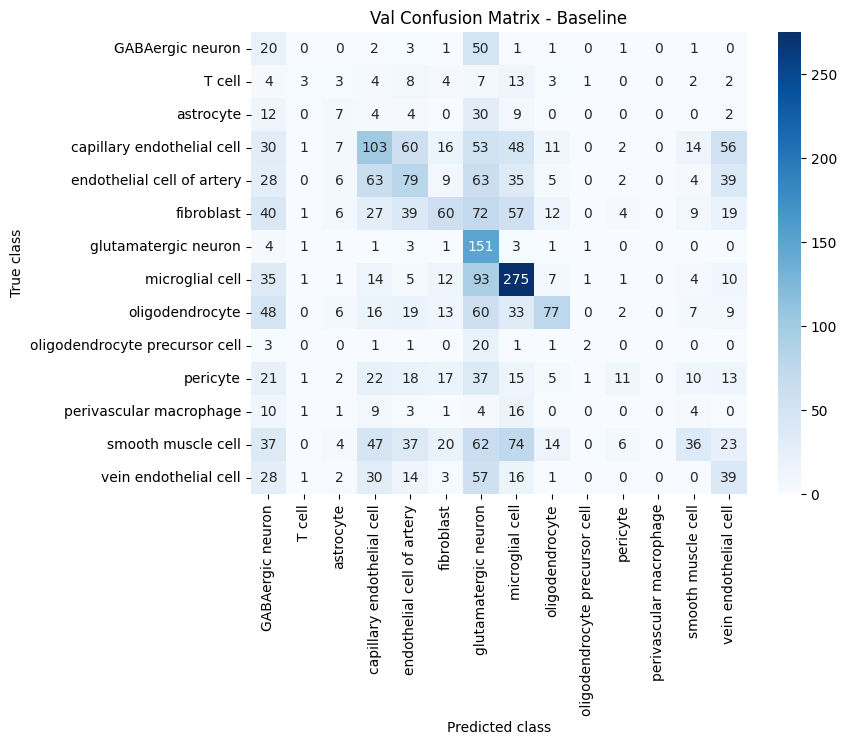

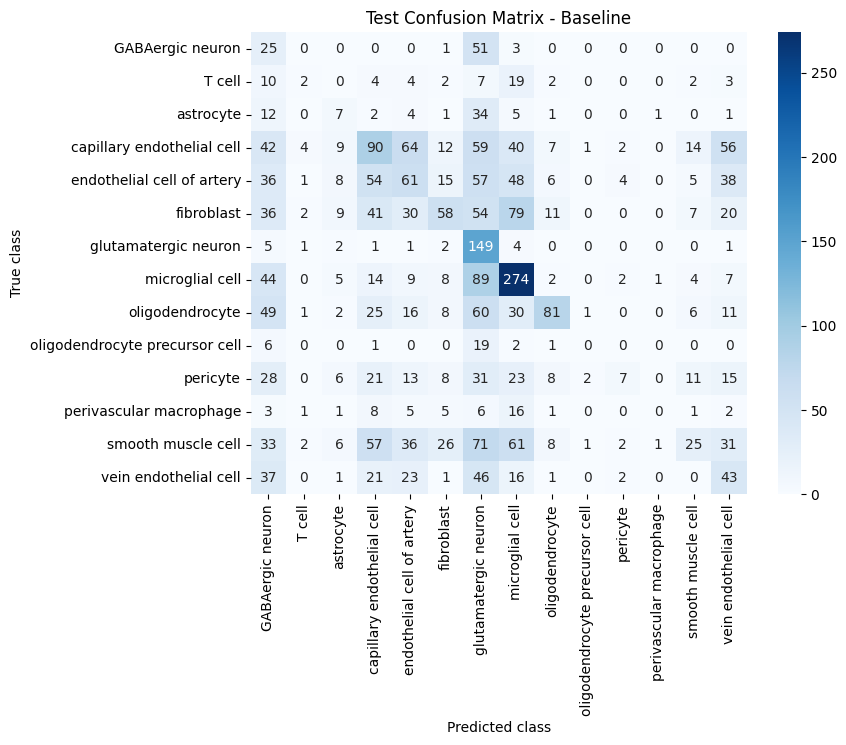

Baseline_Val_acc: 28.77%
Baseline_Val_f1: 20.49%
Baseline_Test_acc: 27.40%
Baseline_Test_f1: 18.46%


In [7]:

# Evaluate baseline embeddings
results_baseline = evaluate_knn(
    train_emb=train_emb_base, train_labels=train_labels,
    val_emb=val_emb_base, val_labels=val_labels,
    test_emb=test_emb_base, test_labels=test_labels,
    label_encoder=label_encoder,
    model_name="Baseline"
)
